# Automatisierte Lösung für OpenAIs LunarLander mit genetischen Algorithmen in Verbindung mit PID-Controllern

@Autor Michael Greif

## Benutzte Bibliotheken

Bibliotheksreferenzen
- OpenAI Gymnasium: https://gymnasium.farama.org/
- NumPy: https://numpy.org/
- Random: https://docs.python.org/3/library/random.html
- Matplotlib: https://matplotlib.org/

In [7]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

## PID-Controller

Der PID-Controller im folgenden Code ist eine Implementierung eines Proportional-Integral-Derivative (PID) Reglers, der in Steuerungssystemen weit verbreitet ist. Dieser Regler zielt darauf ab, eine dynamische Prozesssteuerung zu ermöglichen, indem er kontinuierlich die Differenz (Fehler) zwischen einem gewünschten Sollwert und einem aktuellen Istwert analysiert und darauf reagiert. Der PID-Regler beeinflusst den Steuerungsoutput durch drei 

**Kernkomponenten**:

- **Proportionaler Anteil (Kp)**: Dieser Teil des Reglers reagiert direkt proportional zum aktuellen Fehlerwert. Er veranlasst umso stärkere Anpassungen, je weiter der Istwert vom Sollwert abweicht. Ein gut abgestimmter Kp-Wert hilft, schnelle Korrekturen vorzunehmen, kann aber auch zu Instabilitäten führen, wenn er zu hoch ist.

- **Integraler Anteil (Ki)**: Der Integralaspekt adressiert die Summe der vergangenen Fehler über die Zeit. Er korrigiert stetige Abweichungen, die sich im Zeitverlauf aufsummieren, und sorgt dafür, dass der Regler keine dauerhafte Diskrepanz zwischen Soll- und Istwert besitzt.

- **Derivativer Anteil (Kd)**: Dieser Bestandteil gibt Aufschluss über die Geschwindigkeit der Fehlerveränderung und ist entscheidend zur Dämpfung des Systems. Er reduziert die Reaktion auf große Fehler, wenn der Istwert schnell auf den Sollwert zusteuert, und verhindert Überschwinger.

Die Methode `update` des PID-Controllers berechnet den Steuerungsoutput basierend auf den Werten dieser drei Parameter und dem gegebenen Fehler. Die Methode `reset` dient zur Initialisierung der vorhergehenden Fehler und der Integralsumme, falls ein Neustart oder ein erneuter Steuerprozess notwendig ist.

In [8]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        # Initialisiert den PID-Controller mit den gegebenen Koeffizienten
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def reset(self):
        # Setzt die gespeicherten Zustände zurück
        self.prev_error = 0
        self.integral = 0

    def update(self, error, dt):
        # Berechnet den Ausgang des PID-Reglers auf Basis des aktuellen Fehlers
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output

## Genetischer Trainingsalgorithmus

Die `GeneticAlgorithm`-Klasse stellt eine Methode zur Optimierung von PID-Parameter-Sätzen dar, um die Steuerungseffizienz des LunarLanders in der OpenAI Gym-Umgebung zu maximieren. Der genetische Algorithmus ist von biologischen Evolutionstechniken inspiriert und beinhaltet die Prinzipien der natürlichen Selektion, Kreuzung und Mutation, um über Generationen hinweg qualitativ hochwertige Lösungen zu entwickeln.

**Hauptkomponenten der `GeneticAlgorithm`-Klasse**:
- **Initialisierung**: Der Algorithmus beginnt mit einer zufällig generierten Population von Individuen, wobei jedes Individuum einen Satz von neun PID-Parameterwerten repräsentiert.

- **Fitnessfunktion**: Jedes Individuum wird basierend auf seiner Fähigkeit bewertet, den Lander in der simulierten Umgebung zu steuern. Die Fitness wird durch den erzielten durchschnittlichen Score über mehrere Episoden hinweg ermittelt, wobei dieser Score die Effektivität des PID-Reglers widerspiegelt.

- **Mutation und Crossover**: Die Methoden zur Mutation und Kreuzung erlauben es dem Algorithmus, neue Individuen zu generieren. Mutationen bringen zufällige Veränderungen ein, während die Kreuzung es zwei Elternteilen ermöglicht, ihre Eigenschaften zu einem Kind zu kombinieren. Diese Mechanismen tragen zur genetischen Vielfalt bei und helfen dem Algorithmus, lokale Maxima zu vermeiden.

- **Iterative Optimierung**: Der Algorithmus durchläuft mehrere Generationen und wählt die fittesten Individuen aus jeder Generation aus, um eine neue Population zu erstellen. Im Laufe der Zeit sollte sich die Gesamtfitness der Population erhöhen, was zur Identifizierung der am besten geeigneten PID-Parameter für die Steuerung des Landers führt.

Am Ende der Ausführung liefert die `run`-Methode den besten gefundenen Satz an PID-Parametern sowie eine Historie der Fitnesswerte der besten Individuen aus jeder Generation, was wertvolle Einblicke in die Optimierungsleistung des Algorithmus bietet

In [9]:
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, num_generations, n_episodes):
        """
        Initialisiert die Parameter des genetischen Algorithmus.
        
        Parameters:
        - population_size: Die Anzahl der Individuen in der Population.
        - mutation_rate: Die Rate, mit der Mutationen auftreten.
        - num_generations: Die Anzahl der Generationen, über die der Algorithmus läuft.
        - n_episodes: Die Anzahl der Episoden zur Bewertung der Individuenfitness.
        """
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.num_generations = num_generations
        self.n_episodes = n_episodes

    def initialize_population(self):
        """
        Erzeugt eine initiale Population mit zufälligen Individuen.
        
        Returns:
        - Eine Liste von zufällig initialisierten Individuen.
        """
        return [np.random.rand(9) * 4.0 for _ in range(self.population_size)]

    def fitness(self, individual):
        """
        Bewertet die Fitness eines Individuums durch Simulation in der Umgebung.
        
        Parameters:
        - individual: Ein Array aus PID-Parametern, das bewertet wird.
        
        Returns:
        - Der durchschnittliche erzielte Score über alle Episoden.
        """
        vertical_params = individual[0:3]
        horizontal_params = individual[3:6]
        angle_params = individual[6:9]
        
        env = gym.make("LunarLander-v3", render_mode=None, gravity=-10.0)
        vertical_pid = PIDController(*vertical_params)
        horizontal_pid = PIDController(*horizontal_params)
        angle_pid = PIDController(*angle_params)
        
        total_rewards = []
        
        for episode in range(self.n_episodes):
            state, _ = env.reset()
            vertical_pid.reset()
            horizontal_pid.reset()
            angle_pid.reset()
            total_reward = 0
            done = False
            
            while not done:
                coord_x, coord_y, velocity_x, velocity_y, angle, velocity_angle, left_foot, right_food = state
                
                # Zielwerte definiert
                target_y = 0.0
                target_x = 0.0
                target_angle = 0.0

                # Fehlerberechnungen
                y_error = target_y - coord_y - velocity_y * 2
                x_error = target_x + coord_x + velocity_x * 2
                angle_error = target_angle - angle - velocity_angle
                
                dt = 1.0 / 50.0 

                # Berechnet die Actions basierend auf den PID-Updates
                y_action = vertical_pid.update(y_error, dt)
                x_action = horizontal_pid.update(x_error, dt)
                theta_action = angle_pid.update(angle_error, dt)

                # Bestimmt vertikale, horizontale und Winkelaktionen
                vertical_action = 2 if y_action > 0 else 0
                horizontal_action = 1 if x_action > 0 else 3
                angle_action = 1 if theta_action > 0 else 3

                action = vertical_action
                if vertical_action == 0:
                    action = horizontal_action if abs(x_action) > abs(theta_action) else angle_action

                state, reward, done, _, _ = env.step(action)
                if left_foot and right_food and abs(velocity_y) < 0.005:
                    done = True
                total_reward += reward
            
            total_rewards.append(total_reward)

        env.close()
        return np.mean(total_rewards)

    def mutate(self, individual):
        """
        Führt Mutationen an einem Individuum durch.
        
        Parameters:
        - individual: Ein zu mutierendes Individuum.
        
        Returns:
        - Das mutierte Individuum.
        """
        for i in range(individual.shape[0]):
            if np.random.rand() < self.mutation_rate:
                individual[i] += np.random.normal(0, 1)
        return individual

    def crossover(self, parent1, parent2):
        """
        Kombiniert zwei Elternteile zu einem neuen Kind-Individuum.
        
        Parameters:
        - parent1: Erster Eltern-Individuum.
        - parent2: Zweiter Eltern-Individuum.
        
        Returns:
        - Das erzeugte Kind-Individuum.
        """
        assert len(parent1) == len(parent2) == 9, "Beide Elternteile sollten 9 Elemente haben"
        crossover_point = np.random.randint(len(parent1))
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        return child

    def run(self):
        """
        Führt den genetischen Algorithmus aus, um den besten PID-Parameter-Satz zu finden.

        Returns:
        - best_individual: Das beste gefundene Individuum mit optimierten PID-Parametern.
        - total_fitness: Eine Liste der Fitnesswerte der besten Individuen über Generationen.
        """
        total_fitness = []
        population = self.initialize_population()

        for generation in range(self.num_generations):
            population_fitness = [self.fitness(ind) for ind in population]
            sorted_indices = np.argsort(population_fitness)
            population = [population[i] for i in sorted_indices]
            best_individual = population[-1]
            print(f"Generation {generation + 1}, Best Fitness: {population_fitness[sorted_indices[-1]]}")
            total_fitness.append(population_fitness[sorted_indices[-1]])

            # Elitismus: Übernimmt die besten Individuen in die nächste Generation
            next_generation = population[-int(0.1 * self.population_size):]

            # Fülle die restliche Population mit Nachkommen gefüllt
            while len(next_generation) < self.population_size:
                parent1, parent2 = random.sample(population[-20:], 2)
                child = self.crossover(parent1, parent2)
                self.mutate(child)
                next_generation.append(child)

            population = next_generation

        return best_individual, total_fitness

## Testfunktion der PID-Controller

Die Funktion `play_with_best_params` ermöglicht es, die Effektivität eines optimierten Satzes von PID-Parameterwerten direkt in der „LunarLander-v3“-Gym-Umgebung zu evaluieren. Diese Funktion stellt sicher, dass die Leistungsfähigkeit der zuvor mittels des genetischen Algorithmus ermittelten besten Parameter überprüft und veranschaulicht wird.

**Hauptbestandteile der `play_with_best_params`-Funktion**:
- **Umgebungskonfiguration**: Es wird eine LunarLander-v3-Umgebung mit einer einstellbaren Darstellung (`render_mode`) und einem modifizierten Gravitationswert erstellt, um realistische Testbedingungen zu simulieren.

- **PID-Regler**: Drei PID-Regler werden auf Basis der übergebenen Parameter für die vertikale Position, horizontale Bewegung und Neigung (Winkel) des Landers initialisiert. Diese Regler berechnen kontinuierlich die erforderlichen Anpassungen, um den Lander stabil und präzise zu steuern.

- **Episode-Kontinuum**: In einer festgelegten Anzahl von Episoden (`n_episodes`) wird der Verlauf simuliert. Innerhalb jeder Episode wird der Lander in der Umgebung durch einen iterativen Regelprozess gesteuert:

  1. **Fehlerberechnungen**: Die Funktion berechnet kontinuierlich die Fehler im Vergleich zu den Zielzuständen für Position und Winkel.

  2. **PID-Updates**: Basierend auf den berechneten Fehlern und der verstrichenen Zeit (`dt`) steuert der PID-Regler die Bodenantriebsaktionen des Landers.

  3. **Aktionsentscheidung**: Basierend auf den PID-Outputs werden die Steueraktionen des Landers entschieden, um die Richtung und Intensität der Triebwerke zu bestimmen.

  4. **Sammeln von Ergebnissen**: Jeder Durchgang endet, wenn der Lander erfolgreich landet (bei geringen Geschwindigkeiten) und das Episode-Ergebnis (Score) wird aufgezeichnet.

- Ausgabe der Leistung: Nach allen Episoden wird der mittlere erzielte Score über alle Durchläufe zusammen mit Details zu jedem Landeversuch ausgegeben. Dies ermöglicht eine Analyse, wie gut die optimierten PID-Parameter in realen Szenarien funktionieren.

In [16]:
def play_with_best_params(params, n_episodes=10, render_mode=None):
    """
    Testet die Leistung der besten PID-Parameter in der LunarLander-Umgebung.
    
    Parameters:
    - params: Eine Liste von PID-Parametern in der Form [Kp1, Ki1, Kd1, Kp2, Ki2, Kd2, Kp3, Ki3, Kd3].
    - n_episodes: Die Anzahl der Episoden, die in der Simulation abgespielt werden sollen.
    - render_mode: Der Modus der Darstellung, standardmäßig auf 'human' für visuelle Ausgabe gesetzt.
    """
    # Initialisiert die Umgebung für den LunarLander
    env = gym.make("LunarLander-v3", render_mode=render_mode, gravity=-10.0)
    
    # Erzeugt PID-Regler mit den übergebenen Parametern
    vertical_pid = PIDController(*params[:3])
    horizontal_pid = PIDController(*params[3:6])
    angle_pid = PIDController(*params[6:9])
    
    total_rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        vertical_pid.reset()
        horizontal_pid.reset()
        angle_pid.reset()
        total_reward = 0
        done = False
        
        while not done:
            coord_x, coord_y, velocity_x, velocity_y, angle, velocity_angle, left_foot, right_food = state
            
            # Definiert Zielwerte als Referenzpunkte
            target_y = 0.0
            target_x = 0.0
            target_angle = 0.0

            # Berechnet die Abweichungen bezüglich der Ziele
            y_error = target_y - coord_y - velocity_y * 2
            x_error = target_x + coord_x + velocity_x * 2
            angle_error = target_angle - angle - velocity_angle
            
            dt = 1.0 / 50.0  # Zeitdifferenz für die PID-Berechnung

            # Aktualisiert die PID-Regler und erhält Steueraktionen
            y_action = vertical_pid.update(y_error, dt)
            x_action = horizontal_pid.update(x_error, dt)
            theta_action = angle_pid.update(angle_error, dt)

            # Bestimmt die Aktionsstrategie basierend auf den PID-Ausgaben
            vertical_action = 2 if y_action > 0 else 0
            horizontal_action = 1 if x_action > 0 else 3
            angle_action = 1 if theta_action > 0 else 3

            # Setzt die tatsächliche Aktion für die Umgebung
            action = vertical_action
            if vertical_action == 0:
                action = horizontal_action if abs(x_action) > abs(theta_action) else angle_action

            state, reward, done, _, _ = env.step(action)
            
            # Beendet die Episode, wenn erfolgreich gelandet
            if left_foot and right_food and abs(velocity_y) < 0.005:
                done = True
            total_reward += reward

        total_rewards.append(total_reward)
        print(f"Episode {episode}: {total_reward}")
        print(f"Landing on ({coord_x:.2f},{coord_y:.2f}) with velocity = {velocity_y:.2f}")

    env.close()
    # Ausgabe der durchschnittlichen Belohnung aller Episoden
    print(f"\nMean Reward over {n_episodes} episode(s): {np.mean(total_rewards)}")
    
    return total_rewards

## Training

Im Trainingsteil des Projekts wird die `GeneticAlgorithm`-Klasse instanziiert, um eine evolutionäre Suche nach den besten Satz von PID-Parametern für die gezielte Steuerung des LunarLanders durchzuführen.

**Trainieren des genetischen Algorithmus**:
- **Parameterinitialisierung**: Der genetische Algorithmus wird mit bestimmten Parametern eingerichtet:

    1. Eine `population_size` von 100 garantiert, dass eine signifikante Anzahl individueller PID-Parameterkombinationen untersucht wird.
    2. Die `mutation_rate` von 0.1 sorgt für regelmäßige genetische Veränderungen innerhalb der Population, um die Vielfalt zu erhalten und die Möglichkeit zu geben, aus lokalen Optima auszubrechen.
    3. Der Algorithmus ist konfiguriert, über `num_generations` von 50 zu laufen, was genug Iterationsschritte für die Konvergenz zu einem optimalen Lösungspunkt bereitstellen sollte.
    4. `n_episodes` von 10 bestimmt die Anzahl der Testepisoden, die verwendet werden, um den Fitnesswert eines jeden Individuums während des Trainingsprozesses zu bewerten.

- **Ausführung des genetischen Algorithmus**: Durch die Methode `run` des `GA_PARAMS` Objekts wird der gesamte evolutive Suchprozess gestartet.

    1. Dabei arbeitet der Algorithmus daran, über die definierte Anzahl an Generationen hinweg die bestmöglichen PID-Parameter zu identifizieren.
    2. Das Training gibt die besten gefundenen PID-Parameter (`best_pid_params`) zurück, sowie eine Aufzeichnung der Gesamtfitness während des Trainingspfads (`total_fitness_training`), die nützliche Informationen über den Fortschritt und die Entwicklung der Fitnesswerte liefern kann.

In [11]:
GA_PARAMS = GeneticAlgorithm(
        population_size=75,
        mutation_rate=0.1,
        num_generations=50,
        n_episodes=10
    )

# Ausführen des genetischen Algorithmus um die besten PID-Parameter zu erhalten
best_pid_params, total_fitness_training = GA_PARAMS.run()

Generation 1, Best Fitness: 82.92619383704405
Generation 2, Best Fitness: 129.48368470832287
Generation 3, Best Fitness: 159.67623826448556
Generation 4, Best Fitness: 152.2598256574203
Generation 5, Best Fitness: 159.42950758703873
Generation 6, Best Fitness: 163.03331331251283
Generation 7, Best Fitness: 164.71543903701047
Generation 8, Best Fitness: 163.32126383012647
Generation 9, Best Fitness: 173.29732208258287
Generation 10, Best Fitness: 168.9851406281757
Generation 11, Best Fitness: 176.84305079708332
Generation 12, Best Fitness: 174.67393834369517
Generation 13, Best Fitness: 179.0231713644693
Generation 14, Best Fitness: 172.62611047921982
Generation 15, Best Fitness: 176.25816234162147
Generation 16, Best Fitness: 173.3585150405822
Generation 17, Best Fitness: 172.96511039968405
Generation 18, Best Fitness: 175.1908017763089
Generation 19, Best Fitness: 181.83203252508855
Generation 20, Best Fitness: 173.03584676967705
Generation 21, Best Fitness: 173.58339078517025
Generat

In [12]:
# Ausgabe der besten PID-Parameter
print("Best PID Parameters:")
print("Vertical PID:", best_pid_params[:3])
print("Horizontal PID:", best_pid_params[3:6])
print("Angle PID:", best_pid_params[6:9])

Best PID Parameters:
Vertical PID: [6.64225662 0.01357196 1.02559768]
Horizontal PID: [2.27162746 1.92878466 0.5180359 ]
Angle PID: [4.61473339 4.00106051 2.03612761]


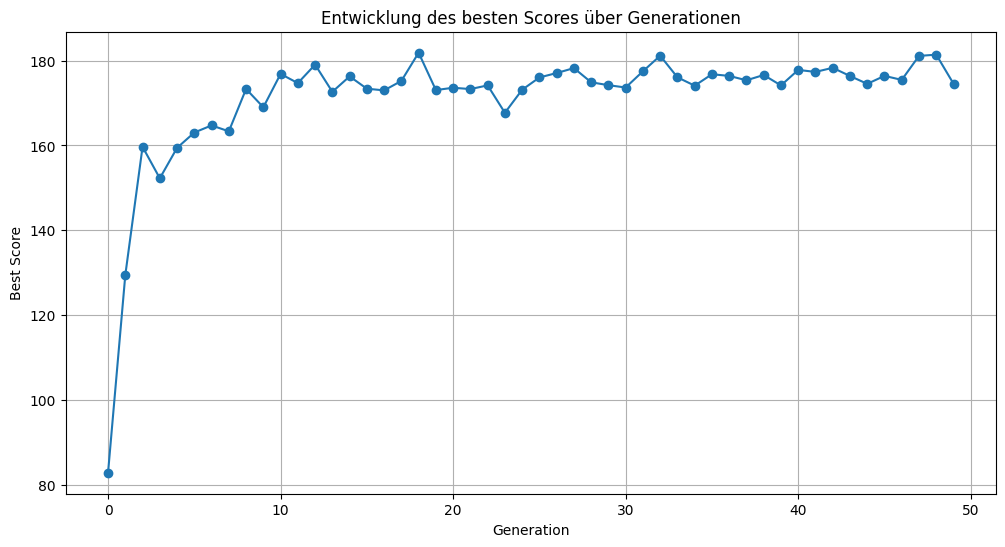

In [13]:
# Plot: des Lernfortschritts
plt.figure(figsize=(12, 6))
plt.plot(range(GA_PARAMS.num_generations), total_fitness_training, marker='o')
plt.title('Entwicklung des besten Scores über Generationen')
plt.xlabel('Generation')
plt.ylabel('Best Score')
plt.grid()
plt.show()

Der obige Plot illustriert die Entwicklung des besten Scores im Verlauf des genetischen Trainings über 50 Generationen. Man erkennt zu Beginn eine deutliche Verbesserung der Scores, was darauf hindeutet, dass die Population schnell geeignete PID-Parameterkombinationen evaluiert und selektiert.

Zwischen den Generationen 10 und 30 gibt es gewisse Schwankungen, die durch die natürliche Variation und Rekombination innerhalb der Population bedingt sind. Jedoch zeigt der Trend insgesamt, dass sich die Scores stabilisieren und im Bereich von 180 bis 190 Punkten einpendeln, was auf eine erfolgreiche Konvergenz hinweist.

## Evaluation

In [20]:
# Evaluation der besten Parameter auf 1000 Testszenarien
print("\nPlaying with the best parameters...\n")
total_rewards = play_with_best_params(best_pid_params, n_episodes=1000)


Playing with the best parameters...

Episode 0: 183.0591062087924
Landing on (-0.02,-0.00) with velocity = -0.00
Episode 1: 157.0687499635692
Landing on (0.15,-0.01) with velocity = 0.00
Episode 2: 142.08587301300489
Landing on (-0.01,-0.00) with velocity = 0.00
Episode 3: 158.69900876231281
Landing on (-0.06,-0.00) with velocity = -0.00
Episode 4: 182.83750802077856
Landing on (-0.03,-0.00) with velocity = 0.00
Episode 5: 175.37062043679853
Landing on (-0.02,-0.00) with velocity = -0.00
Episode 6: -298.94028428528543
Landing on (-0.00,0.01) with velocity = -0.40
Episode 7: 133.7076201295532
Landing on (0.01,-0.00) with velocity = 0.00
Episode 8: 141.77159312918448
Landing on (-0.12,-0.00) with velocity = 0.00
Episode 9: 173.8967416514998
Landing on (0.08,-0.00) with velocity = 0.00
Episode 10: 187.67800010828583
Landing on (0.08,-0.00) with velocity = -0.00
Episode 11: 153.53535651382992
Landing on (0.05,-0.00) with velocity = -0.00
Episode 12: 167.46726617990933
Landing on (0.16,-0.

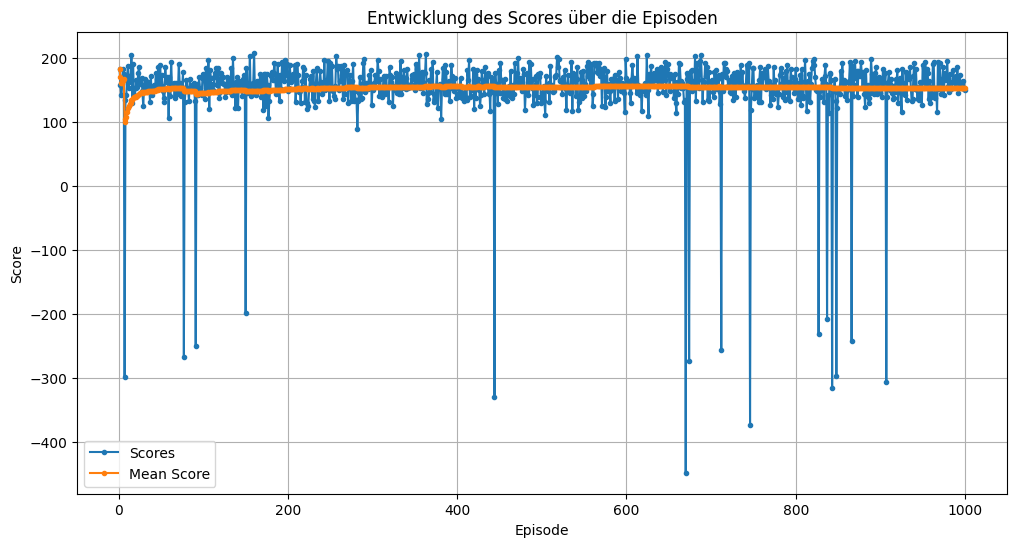

In [21]:
# Plot: Scores über Episoden
plt.figure(figsize=(12, 6))
plt.plot(range(1, 1001), total_rewards, marker=".", label="Scores")
plt.plot(range(1, 1001), [np.mean(total_rewards[:x]) for x in range(1, 1001)], marker=".", label="Mean Score")
plt.title('Entwicklung des Scores über die Episoden')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Score')
plt.grid()
plt.show()

In [15]:
# Visualisierung des Lernfortschrittes für die besten Parameter
print("\nPlaying with the best parameters...\n")
play_with_best_params(best_pid_params, n_episodes=10, render_mode="human")


Playing with the best parameters...

Episode 0: 161.09093233360764
Landing on (0.00,-0.00) with velocity = 0.00
Episode 1: 183.79309314730313
Landing on (-0.02,-0.00) with velocity = -0.00
Episode 2: 149.50870800770375
Landing on (-0.10,-0.00) with velocity = 0.00
Episode 3: 194.57936693365423
Landing on (-0.05,-0.00) with velocity = 0.00
Episode 4: 173.2119560928355
Landing on (-0.07,-0.00) with velocity = 0.00
Episode 5: 123.55249514909566
Landing on (-0.06,-0.00) with velocity = 0.00
Episode 6: 150.46206255998933
Landing on (0.02,-0.01) with velocity = -0.00
Episode 7: 146.18802588257486
Landing on (0.04,-0.00) with velocity = -0.00
Episode 8: 139.2070938438188
Landing on (-0.00,-0.00) with velocity = -0.00
Episode 9: 120.09571599089871
Landing on (-0.08,-0.00) with velocity = -0.00

Mean Reward over 10 episode(s): 154.16894499414815


## Fazit

Das Fazit zu diesem Projekt zeigt, dass der Einsatz eines genetischen Algorithmus zur Optimierung der PID-Parameter zwar knapp nicht das gewünschte Ziel von 200 Punkten erreicht hat, dennoch eine bemerkenswerte Leistung erzielt wurde. Die erzielten Scores liegen konstant im Bereich von 150 Punkten, was auf eine robuste Steuerstrategie hinweist, die sich in ihrer Ausführung als besonders konsistent erweist.

Diese Konsistenz ist von großer Bedeutung, da sie beweist, dass der Lander oft sehr nahe an den idealen Bedingungen arbeitet und zuverlässig gut performt, obwohl das absolute Punktziel nicht vollständig erreicht wurde. Solch ein konsistentes Verhalten ist in dynamischen Systemen wertvoll, da es nicht nur die Leistung, sondern auch die Zuverlässigkeit und den sicheren Betrieb des Landers sicherstellt.